In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests
import json

In [3]:
def get(query, timeout=5, max_retries=5, backoff_factor=0.3):
    """ Выполнить GET-запрос

    :param query: запрос с адресом
    :param timeout: максимальное время ожидания ответа от сервера
    :param max_retries: максимальное число повторных запросов
    :param backoff_factor: коэффициент экспоненциального нарастания задержки
    """
    import time
    import random
    delay = 0
    for i in range(max_retries):
        try:
            response = requests.get(query)
            return response.json()
        except:
            pass
        time.sleep(delay)
        delay = min(delay * backoff_factor, timeout)
        delay += random.random()
    return response

In [4]:
def get_id_page_counts(job_name):
    query = "https://api.hh.ru/vacancies?text=" + job_name
    result = get(query)
    return (result['found'], result['pages'])

In [5]:
test_page_counts = get_id_page_counts('Data scientist')

In [6]:
def get_vacancy_ids(job_name):
    query_data = {
        "search_field": job_name,
        "page": 0
    }
    id_count, page_count = get_id_page_counts(job_name)
    id_list = []
    while query_data['page']<page_count:
        query = "https://api.hh.ru/vacancies?text={search_field}&page={page}".format(**query_data)
        result = get(query)
        query_data["page"] += 1
        for i in range(len(result['items'])):
            id_list.append(result['items'][i]['id'])
    return id_list

In [7]:
test_id_list = get_vacancy_ids('Data scientist')

In [8]:
print(len(test_id_list), test_page_counts)

433 (433, 22)


In [9]:
def parse_append(raw_data, json_data):
    if not json_data:
        json_data={
                'id': [],
                'name': [],
                'schedule': [],
                'employment':[],
                'experience':[],
                'salary_min': [],
                'salary_max': [],
                'currency': []
    }
    json_data['id'].append(raw_data['id'])
    json_data['name'].append(raw_data['name'])
    json_data['schedule'].append(raw_data['schedule']['id'])
    json_data['employment'].append(raw_data['employment']['id'])
    json_data['experience'].append(raw_data['experience']['id'])
    if raw_data['salary']:
        if raw_data['salary']['from'] == None: 
            json_data['salary_min'].append(raw_data['salary']['to'])
        else:
            json_data['salary_min'].append(raw_data['salary']['from'])
        if raw_data['salary']['to'] == None: 
            json_data['salary_max'].append(raw_data['salary']['from'])
        else:
            json_data['salary_max'].append(raw_data['salary']['to'])
        json_data['currency'].append(raw_data['salary']['currency'])
    else:
        json_data['salary_min'].append(None)
        json_data['salary_max'].append(None)
        json_data['currency'].append(None)   
    return json_data

In [10]:
def ids_to_data(id_list):
    job_json = {}
    for i in range(len(id_list)):
        query = "https://api.hh.ru/vacancies/" + id_list[i]
        job_json = parse_append(get(query), job_json)
    return job_json        

In [11]:
def get_job_data(job_name, count=None):
    id_list = get_vacancy_ids(job_name)
    if count:
        return ids_to_data(id_list[:count])
    return ids_to_data(id_list)

In [12]:
job_df=pd.DataFrame(get_job_data('Data scientist'))
job_df.head(5)

,id,name,schedule,employment,experience,salary_min,salary_max,currency
0,34247056,Data Scientist,flexible,full,between1And3,NaN,NaN,None
1,34070637,Computer Vision / Data scientist CV,fullDay,full,between1And3,100000.0,200000.0,RUR
2,34150254,In Vitro Pharmacology Scientist,fullDay,full,between3And6,NaN,NaN,None
3,34065616,Data Scientist,fullDay,full,between3And6,NaN,NaN,None
4,34146009,Data scientist,fullDay,full,between1And3,NaN,NaN,None


In [13]:
job_df.shape

(433, 8)

In [14]:
def normalize_currency(job_entry):
    if job_entry['currency'] == 'USD':
        job_entry['currency'] = 'RUR'
        job_entry['salary'] *= 65
    if job_entry['currency'] == 'EUR':
        job_entry['currency'] = 'RUR'
        job_entry['salary'] *= 75
    return job_entry

In [15]:
def normalize_salary(job_df):
    job_df.insert(loc=4, column='salary', value=((job_df['salary_min']+job_df['salary_max'])/2))
    job_df.apply(normalize_currency, 1)
    return job_df.drop(columns=['salary_min', 'salary_max'])

In [17]:
job_df_list={
    'data scientist': {},
    'бизнес аналитик': {},
    'web разработчик': {},
    'python программист': {}
}
for i in job_df_list.keys():
    job_df_list[i] = pd.DataFrame(get_job_data(i))

In [29]:
job_df_full = job_df_list['бизнес аналитик'].head(400)
job_df_full.insert(loc=2, column='job_type', value = 'бизнес аналитик')
job_df_full = job_df_full.append(job_df_list['python программист'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('python программист')
job_df_full = job_df_full.append(job_df_list['web разработчик'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('web разработчик')
job_df_full = job_df_full.append(job_df_list['data scientist'].head(400))
job_df_full['job_type'] = job_df_full['job_type'].fillna('data scientist')

In [30]:
job_df_full = normalize_salary(job_df_full)
job_df_full.head()

,currency,employment,experience,id,salary,job_type,name,schedule
0,RUR,full,between1And3,33877075,150000.0,бизнес аналитик,Бизнес-аналитик,fullDay
1,RUR,full,between3And6,34241360,100000.0,бизнес аналитик,Аналитик бизнес-процессов / бизнес-аналитик,fullDay
2,RUR,full,between3And6,34050009,90000.0,бизнес аналитик,Бизнес-аналитик,fullDay
3,RUR,full,between1And3,34148183,125000.0,бизнес аналитик,Менеджер проекта/ бизнес-аналитик,fullDay
4,RUR,full,between1And3,32203964,130000.0,бизнес аналитик,Старший бизнес-аналитик СЭД,fullDay


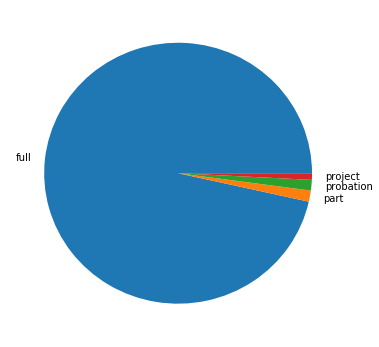

In [20]:
job_df_class = job_df_full.groupby('employment').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")

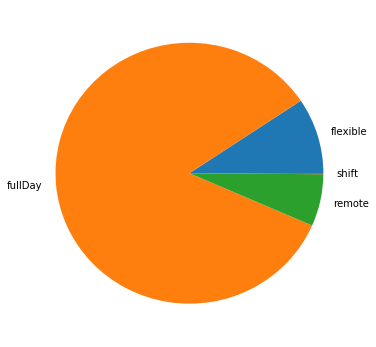

In [21]:
job_df_class = job_df_full.groupby('schedule').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")

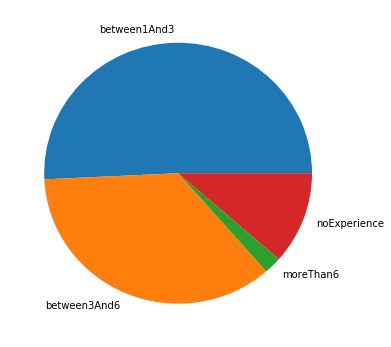

In [22]:
job_df_class = job_df_full.groupby('experience').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")

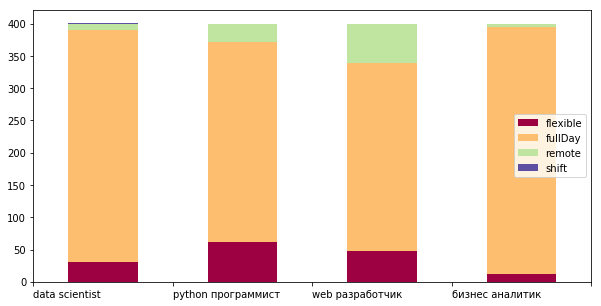

In [23]:
x_var = 'job_type'
groupby_var = 'schedule'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins, np.unique(job_df_full[x_var]).tolist(), rotation=0, horizontalalignment='left')
plt.show()

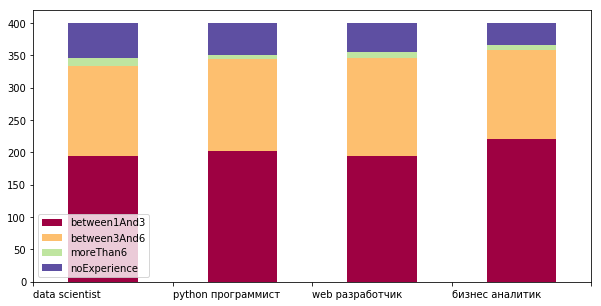

In [24]:
x_var = 'job_type'
groupby_var = 'experience'
job_df_agg = job_df_full.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [job_df_full[x_var].astype('category').cat.codes.values.tolist() for i, job_df_full in job_df_agg]
plt.figure(figsize=(10,5))
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, job_df_full[x_var].unique().__len__(), color=colors[:len(vals)], rwidth=0.5, stacked=True, density=False)
plt.legend({group:col for group, col in zip(np.unique(job_df_full[groupby_var]).tolist(), colors[:len(vals)])})
plt.xticks(bins, np.unique(job_df_full[x_var]).tolist(), rotation=0, horizontalalignment='left')
plt.show()

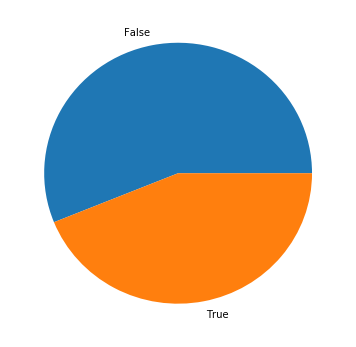

In [31]:
job_df_class = job_df_full.groupby(job_df_full['salary']>0).size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")
plt.show()

In [32]:
salary_df = job_df_full[job_df_full['salary']>0]

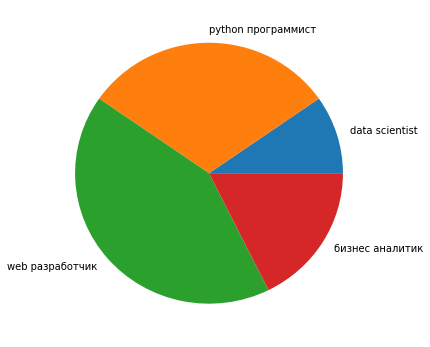

In [33]:
job_df_class = salary_df.groupby('job_type').size()
job_df_class.plot(kind='pie', figsize=(6, 6), label="")

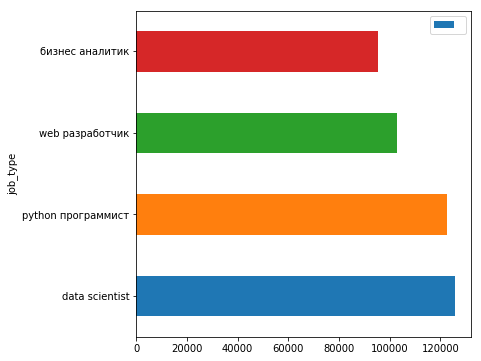

In [34]:
# Average wage per job type
job_df_class = salary_df.groupby('job_type').sum()
job_df_class['salary'] /= salary_df.groupby('job_type').size()
job_df_class.plot(kind='barh', y='salary', figsize=(6, 6), label="")